In [1]:
import numpy as np

import jax
import jax.numpy as jnp
from jax import random

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

from absl import app
from absl import flags
import sys

import os
import time

from kernels import *
from utils import *
from kernel_sca_inducing_points import *

(330, 50, 114)
(330, 50, 114)
(330, 50, 114)
(330, 50, 114)
(330, 50, 114)
(330, 50, 114)


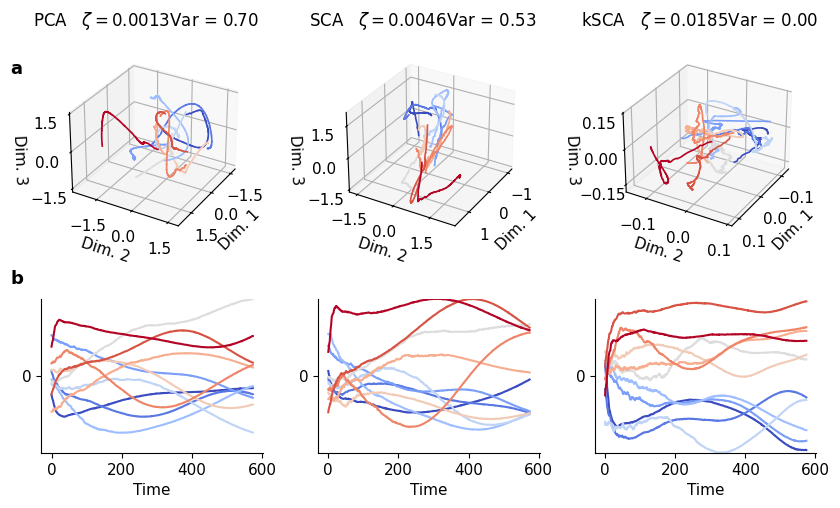

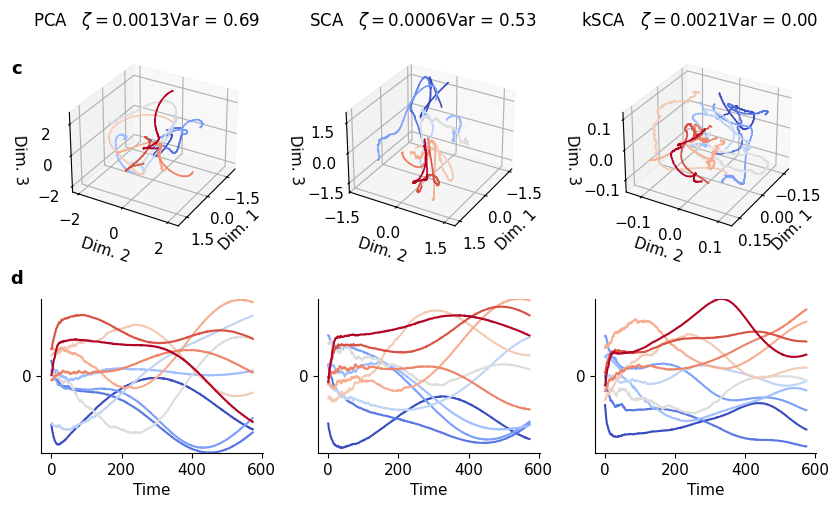

In [3]:
sigma = 4.0
l2 = 0.1

X_train = jnp.load('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/X_train_50trials.npy')
X_test = jnp.load('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/X_test_50trials.npy')
RTs = jnp.load('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/RTs_50trials.npy')

params = [
jnp.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/single_trials/PCA/PCs_PCA_3d_sigma{sigma}_proj_dims50_l2{l2}.npy').T,
jnp.linalg.qr(jnp.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/single_trials/SCA/U_SCA_3d_sigma{sigma}_proj_dims50_l2{l2}.npy'))[0],
jnp.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/single_trials/kSCA/params_kSCA_3d_sigma{sigma}_proj_dims50_l2{l2}.npy',allow_pickle=True).tolist()
]

ls_train = [
jnp.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/single_trials/PCA/Y_mean_PCA_3d_sigma{sigma}_proj_dims50_l2{l2}.npy'),
jnp.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/single_trials/SCA/Y_mean_SCA_3d_sigma{sigma}_proj_dims50_l2{l2}.npy'),
jnp.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/single_trials/kSCA/Y_mean_kSCA_3d_sigma{sigma}_proj_dims50_l2{l2}.npy')
]


ls_train_all = [
jnp.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/single_trials/PCA/Y_PCA_3d_sigma{sigma}_proj_dims50_l2{l2}.npy'),
jnp.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/single_trials/SCA/Y_SCA_3d_sigma{sigma}_proj_dims50_l2{l2}.npy'),
jnp.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/single_trials/kSCA/Y_kSCA_3d_sigma{sigma}_proj_dims50_l2{l2}.npy')
]


ls_test = [
jnp.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/single_trials/PCA/Y_mean_test_PCA_3d_sigma{sigma}_proj_dims50_l2{l2}.npy'),
jnp.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/single_trials/SCA/Y_mean_test_SCA_3d_sigma{sigma}_proj_dims50_l2{l2}.npy'),
jnp.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/single_trials/kSCA/Y_mean_test_kSCA_3d_sigma{sigma}_proj_dims50_l2{l2}.npy')
]



ls_test_all = [
jnp.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/single_trials/PCA/Y_test_PCA_3d_sigma{sigma}_proj_dims50_l2{l2}.npy'),
jnp.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/single_trials/SCA/Y_test_SCA_3d_sigma{sigma}_proj_dims50_l2{l2}.npy'),
jnp.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/single_trials/kSCA/Y_test_kSCA_3d_sigma{sigma}_proj_dims50_l2{l2}.npy')
]

def get_fig_DDMs(ls, ls_all, X_train, X_test, params, test, kernel_function=K_X_Y_squared_exponential, fontsize=11, id1='a', id2='b'):
    fig = plt.figure(figsize=(10, 6))

    gs = gridspec.GridSpec(2, 3, height_ratios=[2, 1])

    axs = [[fig.add_subplot(gs[0, i], projection='3d') for i in range(3)],
        [fig.add_subplot(gs[1, i]) for i in range(3)]]


    def plot_3D_K_coded(ax, Y, Y_all, X_train, X_test,  params, title, i, test, kernel_function=K_X_Y_squared_exponential, elevation=90, azimuth=30, rotate=True):
        K, _,_=Y.shape
        cmap = plt.get_cmap('coolwarm', K)
        for k in range(K):
            x = Y[k, 0, :]
            y = Y[k, 1, :]
            z = Y[k, 2, :] 
        

            color = cmap(k / (K - 1)) 
            ax.plot(x, y, z, linestyle='-', color=color, linewidth=1.2)

            if rotate:
                ax.view_init(elev=elevation, azim=azimuth)
        
        ax.xaxis.set_major_locator(MaxNLocator(3))
        ax.yaxis.set_major_locator(MaxNLocator(3))
        ax.zaxis.set_major_locator(MaxNLocator(3))

        ax.set_xlabel('Dim. 1', fontsize=fontsize)
        ax.set_ylabel('Dim. 2', fontsize=fontsize)
        ax.set_zlabel('Dim. 3', fontsize=fontsize)
        ax.set_box_aspect(aspect=None, zoom=0.85)
    
        print(X_train.shape)
        var = 0
        if i != 2:
            if test:
                
                var = var_explained(X_test, params)
            else:
                var = var_explained(X_train, params)
        # else:
        #     K, N, T = X_train.shape
        #     A_train = jnp.swapaxes(X_train, 0, 1).reshape(N,-1)    
        #     _, _, _, _, alpha  = get_alpha(params, A_train, X_train, kernel_function, d=3)
        #     _, _, l2, scale = get_params(params, kernel_function=kernel_function)
        #     print(alpha.shape)
        #     if test:
        #         A_test = jnp.swapaxes(X_test, 0, 1).reshape(N,-1) 
        #         var = var_explained_kernel(alpha, kernel_function, A_train, X_train, l2, scale, A_test=A_test, X_test=X_test, test=True, compute_matrix=False)
        #     else:
        #         var = var_explained_kernel(alpha, kernel_function, A_train, X_train, l2, scale, compute_matrix=False)


        ax.set_title(f'{title}   ' + rf'$\zeta = {jnp.abs(compute_S_all_pairs(Y_all)):.4f}$' + f'Var = {var:.2f}   ')
        

    K, N, T = ls[0].shape
    titles = ['PCA', 'SCA', 'kSCA']
    for i in range(len(ls)):
        plot_3D_K_coded(axs[0][i], ls[i], ls_all[i], X_train, X_test,  params[i], titles[i], i, test, elevation=30, azimuth=30, rotate=True)
        axs[0][i].tick_params(axis='both', which='major', labelsize=fontsize)

        cmap = plt.get_cmap('coolwarm', K)
        for k in range(K):
            color = cmap(k / (K - 1)) 
            axs[1][i].plot(ls[i][k, 0, :], color=color)
        axs[1][i].spines[['top', 'right']].set_visible(False)
        axs[1][i].set_ylim(-jnp.max(jnp.abs(ls[i][:, 0, :])), jnp.max(jnp.abs(ls[i][:, 0, :])))
        axs[1][i].set_yticks([0])
        axs[1][i].tick_params(axis='both', which='major', labelsize=fontsize)
        axs[1][i].set_xlabel('Time', fontsize=fontsize)
                
    plt.subplots_adjust(wspace=0.25, hspace=0)
    fig.text(0.1, 0.75, id1, ha='center', va='center', rotation='horizontal', fontsize=fontsize+2, fontweight='bold')
    fig.text(0.1, 0.4, id2, ha='center', va='center', rotation='horizontal', fontsize=fontsize+2, fontweight='bold')
   

get_fig_DDMs(ls_train, ls_train_all,  X_train, X_test, params, test = False, fontsize=11, id1='a', id2='b')
get_fig_DDMs(ls_test, ls_test_all,  X_train, X_test, params, test = True, fontsize=11, id1='c',id2='d')